In [83]:
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline

def exp_model(x,a,c):
    return a * x ** c 

def log_model(x, a, b, c, n):
    return a * (1 - n * np.exp(-b * x)) + c
# def log_model(x, a, b, c, n):
#     return a * (1 - n * np.exp(-b * x)) + c

def fit_log (full_metrics, xval, yval, groupby, ercc_only = False):
    return_df = pd.DataFrame()
    for feature in list(set(full_metrics[groupby].values.tolist())):
        df_slice = full_metrics[full_metrics[groupby] == feature]
        ercc_slice = df_slice[[x.startswith('ERCC-') for x in df_slice.gene]]
        if ercc_only == True:
            input_slice = ercc_slice
        else:
            input_slice = df_slice
        
        input_slice = input_slice.loc[:,[xval, yval]].dropna()
        x = input_slice[xval].values
        y = input_slice[yval].values
        popt, pcov = curve_fit(log_model, x, y)
        df_slice['fit'] = log_model(df_slice[xval].values, *popt)
        return_df = return_df.append(df_slice)
    return return_df

def fit_exp (full_metrics, xval, yval, groupby, ercc_only = False):
    return_df = pd.DataFrame()
    for feature in list(set(full_metrics[groupby].values.tolist())):
        df_slice = full_metrics[full_metrics[groupby] == feature]
        ercc_slice = df_slice[[x.startswith('ERCC-') for x in df_slice.gene]]
        if ercc_only == True:
            input_slice = ercc_slice
        else:
            input_slice = df_slice
        
        input_slice = input_slice.loc[:,[xval, yval]].dropna()
        x = input_slice[xval].values
        y = input_slice[yval].values
        popt, pcov = curve_fit(exp_model, x, y)
        df_slice['fit'] = exp_model(df_slice[xval].values, *popt)
        return_df = return_df.append(df_slice)
    return return_df

def fit_poly (full_metrics, xval, yval, poly_num, groupby, ercc_only = False):
    return_df = pd.DataFrame()
    for feature in list(set(full_metrics[groupby].values.tolist())):
        df_slice = full_metrics[full_metrics[groupby] == feature]
        ercc_slice = df_slice[[x.startswith('ERCC-') for x in df_slice.gene]]
        if ercc_only == True:
            input_slice = ercc_slice
        else:
            input_slice = df_slice
            
        input_slice = input_slice.loc[:,[xval, yval]].dropna()
        x = input_slice[xval].values
        y = input_slice[yval].values
        z = np.polyfit(x, y, poly_num)
        p = np.poly1d(z)
        df_slice['fit'] = p(df_slice[xval].values)
        
        # determine global max
        max_df = pd.DataFrame()
        max_df['xval'] = np.linspace(0, np.nanmax(x), 100)
        max_df['yval'] = p(np.linspace(0, np.nanmax(x), 100))
        df_slice['max_cut'] = max_df[max_df.yval == max_df.yval.max()].xval.values.tolist()[0]
        
        return_df = return_df.append(df_slice)
    return return_df

def fit_spline (full_metrics, xval, yval, poly_num, groupby, ercc_only = False):
    return_df = pd.DataFrame()
    for feature in list(set(full_metrics[groupby].values.tolist())):
        df_slice = full_metrics[full_metrics[groupby] == feature]
        ercc_slice = df_slice[[x.startswith('ERCC-') for x in df_slice.gene]]
        if ercc_only == True:
            input_slice = ercc_slice
        else:
            input_slice = df_slice
            
        input_slice = input_slice.loc[:,[xval, yval]].dropna()
        input_slice = input_slice.sort_values(xval)
        x = input_slice[xval].values
        y = input_slice[yval].values
        spl = UnivariateSpline(x, y, k=poly_num)
        df_slice['fit'] = spl(df_slice[xval].values)
        
        # determine global max
        max_df = pd.DataFrame()
        max_df['xval'] = np.linspace(0, np.nanmax(x), 100)
        max_df['yval'] = p(np.linspace(0, np.nanmax(x), 100))
        df_slice['max_cut'] = max_df[max_df.yval == max_df.yval.max()].xval.values.tolist()[0]
        
        return_df = return_df.append(df_slice)
    return return_df


def bin_entropy(starting_adata, pre_adata, groupby = 'patient', bin_size = 10, log = True):
    if log == True:
        input_adata = (np.log(pre_adata + 1)
                        .astype(int)
                        .loc[:,starting_adata.obs_names.values.tolist()]
                      )
    else:
        input_adata = (pre_adata
                .astype(int)
                .loc[:,starting_adata.obs_names.values.tolist()]
              )
    return_df = pd.DataFrame()
    for feature in tqdm.tqdm(list(set(starting_adata.obs[groupby]))):
        feature_slice = input_adata.loc[:, starting_adata[starting_adata.obs[groupby] == feature].obs_names.tolist()]
        binned_entropy_list = []

        for row in range(feature_slice.shape[0]):
            max_value = np.max(feature_slice.iloc[row,:].values)
            if max_value == 0:
                bin_seq = [0,bin_size,int(bin_size*2)]
            else:
                bin_seq = [x for x in range(0,int(max_value),bin_size)]
                if max_value % bin_size != 0:
                    bin_seq = bin_seq + [bin_seq[-1] + bin_size]
            binned_counts,edges = np.histogram(feature_slice.iloc[row,:].values, bins = bin_seq)
            binned_probs = binned_counts / np.sum(binned_counts)
            binned_slice_entropy = stats.entropy(binned_probs)
            binned_entropy_list.append(binned_slice_entropy)

        slice_df = pd.DataFrame({'exp_entropy':binned_entropy_list})
        slice_df[groupby] = feature
        slice_df['gene'] = feature_slice.index.values.tolist()
        return_df = return_df.append(slice_df)
    return return_df

def entropy(starting_adata, pre_adata, groupby = 'patient', log = True):
    if log == True:
        input_adata = (np.log(pre_adata + 1)
                        .astype(int)
                        .loc[:,starting_adata.obs_names.values.tolist()]
                      )
    else:
        input_adata = (pre_adata
                .astype(int)
                .loc[:,starting_adata.obs_names.values.tolist()]
              )
    return_df = pd.DataFrame()
    for feature in tqdm.tqdm(list(set(starting_adata.obs[groupby]))):
        feature_slice = input_adata.loc[:, starting_adata[starting_adata.obs[groupby] == feature].obs_names.tolist()]
        binned_entropy_list = []

        for row in range(feature_slice.shape[0]):

            binned_slice_entropy = stats.entropy(feature_slice.iloc[row,:].values / feature_slice.iloc[row,:].values.sum())
            binned_entropy_list.append(binned_slice_entropy)

        slice_df = pd.DataFrame({'exp_entropy':binned_entropy_list})
        slice_df[groupby] = feature
        slice_df['gene'] = feature_slice.index.values.tolist()
        return_df = return_df.append(slice_df)
    return return_df

def adata_median (starting_adata, pre_adata, groupby = 'patient', log = True):
    if log == True:
        input_adata = (np.log(pre_adata + 1)
                        .astype(int)
                        .loc[:,starting_adata.obs_names.values.tolist()]
                      )
    else:
        input_adata = (pre_adata
                .astype(int)
                .loc[:,starting_adata.obs_names.values.tolist()]
              )
    return_df = pd.DataFrame()
    for feature in tqdm.tqdm(list(set(starting_adata.obs[groupby]))):
        feature_slice = input_adata.loc[:, starting_adata[starting_adata.obs[groupby] == feature].obs_names.tolist()]
        slice_df = pd.DataFrame({'exp_median':np.median(feature_slice.values, axis = 1).flatten().tolist()})
        slice_df[groupby] = feature
        slice_df['gene'] = feature_slice.index.values.tolist()
        return_df = return_df.append(slice_df)
    return return_df

def adata_mean (starting_adata, pre_adata, groupby = 'patient', log = True):
    if log == True:
        input_adata = (np.log(pre_adata + 1)
                        .astype(int)
                        .loc[:,starting_adata.obs_names.values.tolist()]
                      )
    else:
        input_adata = (pre_adata
                .astype(int)
                .loc[:,starting_adata.obs_names.values.tolist()]
              )
    return_df = pd.DataFrame()
    for feature in tqdm.tqdm(list(set(starting_adata.obs[groupby]))):
        feature_slice = input_adata.loc[:, starting_adata[starting_adata.obs[groupby] == feature].obs_names.tolist()]
        slice_df = pd.DataFrame({'exp_mean':np.mean(feature_slice.values, axis = 1).flatten().tolist()})
        slice_df[groupby] = feature
        slice_df['gene'] = feature_slice.index.values.tolist()
        return_df = return_df.append(slice_df)
    return return_df

def adata_coefvar (starting_adata, pre_adata, groupby = 'patient', log=True):
    if log == True:
        input_adata = (np.log(pre_adata + 1)
                        .astype(int)
                        .loc[:,starting_adata.obs_names.values.tolist()]
                      )
    else:
        input_adata = (pre_adata
                .astype(int)
                .loc[:,starting_adata.obs_names.values.tolist()]
              )
    return_df = pd.DataFrame()
    for feature in tqdm.tqdm(list(set(starting_adata.obs[groupby]))):
        feature_slice = input_adata.loc[:, starting_adata[starting_adata.obs[groupby] == feature].obs_names.tolist()]
        
        coefvar = np.std(feature_slice.values, axis = 1) / np. mean(feature_slice.values, axis = 1)
        
        slice_df = pd.DataFrame({'exp_coefvar':coefvar.flatten().tolist()})
        slice_df[groupby] = feature
        slice_df['gene'] = feature_slice.index.values.tolist()
        return_df = return_df.append(slice_df)
    return return_df

def adata_iqr (starting_adata, pre_adata, groupby = 'patient', log = True):
    if log == True:
        input_adata = (np.log(pre_adata + 1)
                        .astype(int)
                        .loc[:,starting_adata.obs_names.values.tolist()]
                      )
    else:
        input_adata = (pre_adata
                .astype(int)
                .loc[:,starting_adata.obs_names.values.tolist()]
              )
    return_df = pd.DataFrame()
    for feature in tqdm.tqdm(list(set(starting_adata.obs[groupby]))):
        feature_slice = input_adata.loc[:, starting_adata[starting_adata.obs[groupby] == feature].obs_names.tolist()]
        
        q25 = np.percentile(feature_slice.values, 25, axis = 1)
        q75 = np.percentile(feature_slice.values, 75, axis = 1)
        iqr = np.abs(q75-q25)
        
        slice_df = pd.DataFrame({'exp_iqr':iqr.flatten().tolist()})
        slice_df[groupby] = feature
        slice_df['gene'] = feature_slice.index.values.tolist()
        return_df = return_df.append(slice_df)
    return return_df

def adata_std (starting_adata, pre_adata, groupby = 'patient', log=True):
    if log == True:
        input_adata = (np.log(pre_adata + 1)
                        .astype(int)
                        .loc[:,starting_adata.obs_names.values.tolist()]
                      )
    else:
        input_adata = (pre_adata
                .astype(int)
                .loc[:,starting_adata.obs_names.values.tolist()]
              )
    return_df = pd.DataFrame()
    for feature in tqdm.tqdm(list(set(starting_adata.obs[groupby]))):
        feature_slice = input_adata.loc[:, starting_adata[starting_adata.obs[groupby] == feature].obs_names.tolist()]
        
        slice_df = pd.DataFrame({'exp_std':np.std(feature_slice.values, axis = 1).flatten().tolist()})
        slice_df[groupby] = feature
        slice_df['gene'] = feature_slice.index.values.tolist()
        return_df = return_df.append(slice_df)
    return return_df

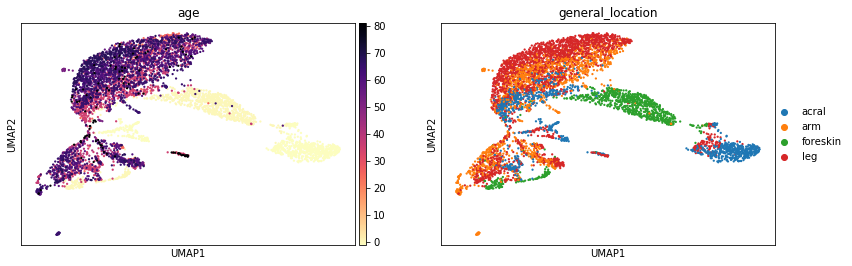

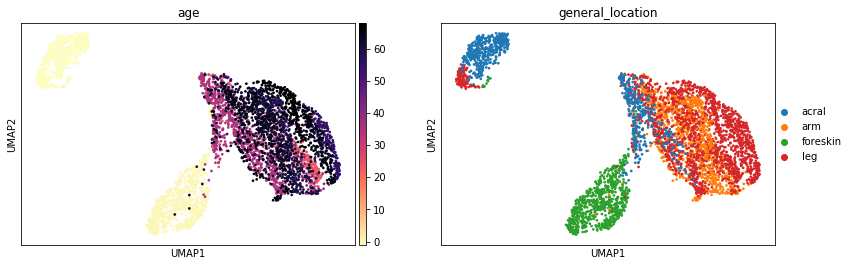

Completed


In [84]:
###############################################
###############################################
# Setup
# This chuck ingests pre-computed variables
###############################################
###############################################

# [Shift + Return] to run chunks 

###############################################

# settings
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

%reload_ext autoreload
%autoreload 2
from scanpy_helpers import *
warnings.filterwarnings('ignore')
%matplotlib inline

# import data from s3
for file in ['adata_subset1', 'adata_subset2', 'full_adata', 'pre_adata','adata_subset1_KRT','raw_adata']:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var

# drop patients due to low cell count
adata_subset2_filtered = adata_subset2[[x not in ['A1015LM',
                                                'A1017LM',
                                                'A1012M'] for x in adata_subset2.obs.patient.tolist()]] 

# plot full data
sc.pl.umap(full_adata, color=['age','general_location'], cmap = 'magma_r')
sc.pl.umap(adata_subset2_filtered, color=['age','general_location'], cmap = 'magma_r')

print('Completed')


## ERCC transcripts used as model for relationship between expression level and dispersion independent of biological variance
- patient = A1020LM

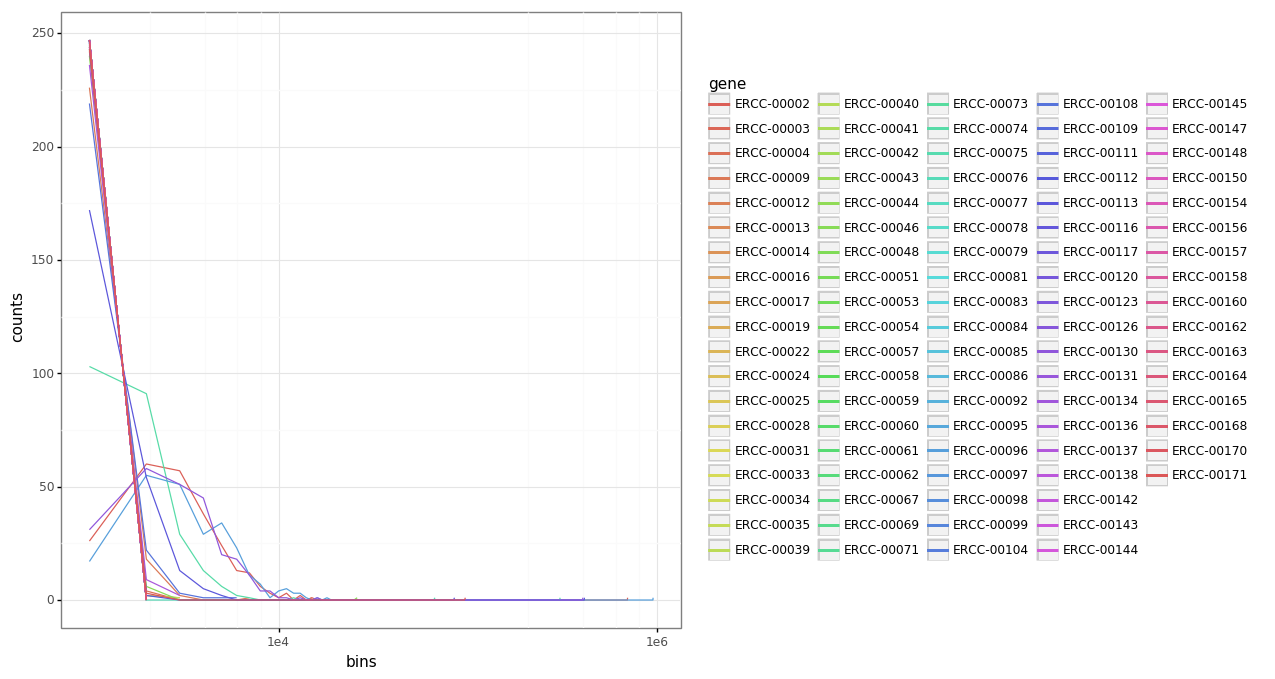

<ggplot: (8751827090254)>


In [85]:
pre_adata_ercc = pre_adata[[x.startswith('ERCC-') for x in pre_adata.index]]
metrics_df_ercc[metrics_df_ercc.patient == 'A1020LM'].dropna().exp_mean.values.tolist()
starting_adata = adata_subset2
input_pre = pre_adata_ercc
log = False
groupby='patient'
bin_size = 1000
if log == True:
    input_adata = (np.log(input_pre + 1)
                    .astype(int)
                    .loc[:,starting_adata.obs_names.values.tolist()]
                  )
else:
    input_adata = (input_pre
            .astype(int)
            .loc[:,starting_adata.obs_names.values.tolist()]
          )
return_df = pd.DataFrame()
feature = 'A1020LM'
feature_slice = input_adata.loc[:, starting_adata[starting_adata.obs[groupby] == feature].obs_names.tolist()]

return_df = pd.DataFrame()
for row in range(feature_slice.shape[0]):
    max_value = np.max(feature_slice.iloc[row,:].values)
    if max_value == 0:
        bin_seq = [0,bin_size,int(bin_size*2)]
    else:
        bin_seq = [x for x in range(0,int(max_value),bin_size)]
        if max_value % bin_size != 0:
            bin_seq = bin_seq + [bin_seq[-1] + bin_size]
    binned_counts,edges = np.histogram(feature_slice.iloc[row,:].values, bins = bin_seq)
    df = pd.DataFrame({'counts':binned_counts,
                      'bins':bin_seq[1:]})
    df['gene'] = feature_slice.index[row]
    return_df = return_df.append(df)
    
transcripts = metrics_df_ercc[metrics_df_ercc.patient == 'A1020LM'][metrics_df_ercc.exp_mean > 0].gene.tolist()
return_df[[x in transcripts for x in return_df.gene]]

print(ggplot(return_df)
      +theme_bw()
     +geom_line(aes('bins','counts',color='gene'))
     +scale_x_log10()
     )

## The relationship between dispersion metric and mean expression
Metrics = entropy, interquartile range (IQR), coefficient of variation (coefvar), and standard deviation (std)

Metrics are calculated for each set of cells derived from individual patients.

entropy ref: https://www.pnas.org/content/105/28/9709#sec-7
(calculated from read count frequency distribution)

ERCC transcripts span a large expression range, and it is assumed that observed dispersion originates from technical noise.

STD and IQR indicate potential PCR saturation as dispersion decreases with transcript mean great than approximately log (2-3).

100%|██████████| 16/16 [00:00<00:00, 36.56it/s]


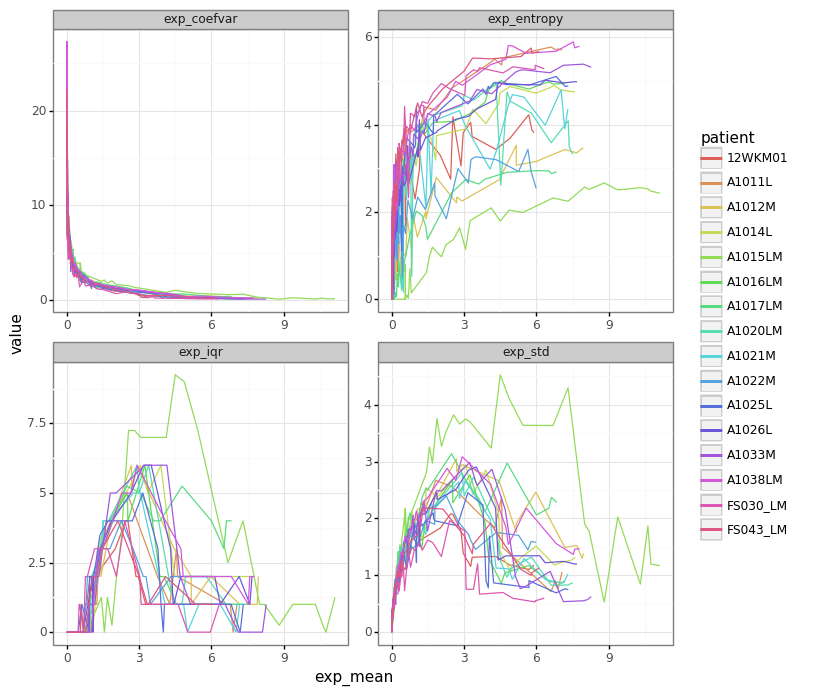

<ggplot: (-9223363285060868110)>


In [86]:
starting_adata = adata_subset2
pre_adata_ercc = pre_adata[[x.startswith('ERCC-') for x in pre_adata.index]]

entropy_df_ercc = entropy(adata_subset2, pre_adata_ercc, log = False)
median_df_ercc = adata_median (adata_subset2, pre_adata_ercc)
mean_df_ercc = adata_mean (adata_subset2, pre_adata_ercc)
coefvar_df_ercc = adata_coefvar (adata_subset2, pre_adata_ercc)
iqr_df_ercc = adata_iqr (adata_subset2, pre_adata_ercc)
std_df_ercc = adata_std (adata_subset2, pre_adata_ercc)

groupby='patient'
for idx,sub_df in enumerate([entropy_df_ercc, median_df_ercc, coefvar_df_ercc, 
                             iqr_df_ercc, mean_df_ercc, std_df_ercc]):
    if idx == 0:
        metrics_df_ercc = sub_df
    else:
        metrics_df_ercc = pd.merge(metrics_df_ercc, sub_df, 'right', ['gene',groupby])

plot_df = pd.melt(metrics_df_ercc, id_vars=['patient',
                                           'gene',
                                           'exp_median',
                                           'exp_mean'])

print(ggplot(plot_df)
     +theme_bw()
     +theme(panel_spacing = 0.3)
     +geom_line(aes('exp_mean','value',color='patient'))
     +facet_wrap('~variable', scales = 'free'))

## Regressing out the effect of mean expression from dispersion
Using ERCC transcripts, the relation between mean and STD was modeled.

Mean-normalized root-mean-squared-deviation (NRMSD) summarizes model polynomial fits.

The max fitted value in the log(counts) ERRC abundance range was used to determine mean expression level cutoff for observed transcripts.

exp_std NRMSD = 0.3449281281896021


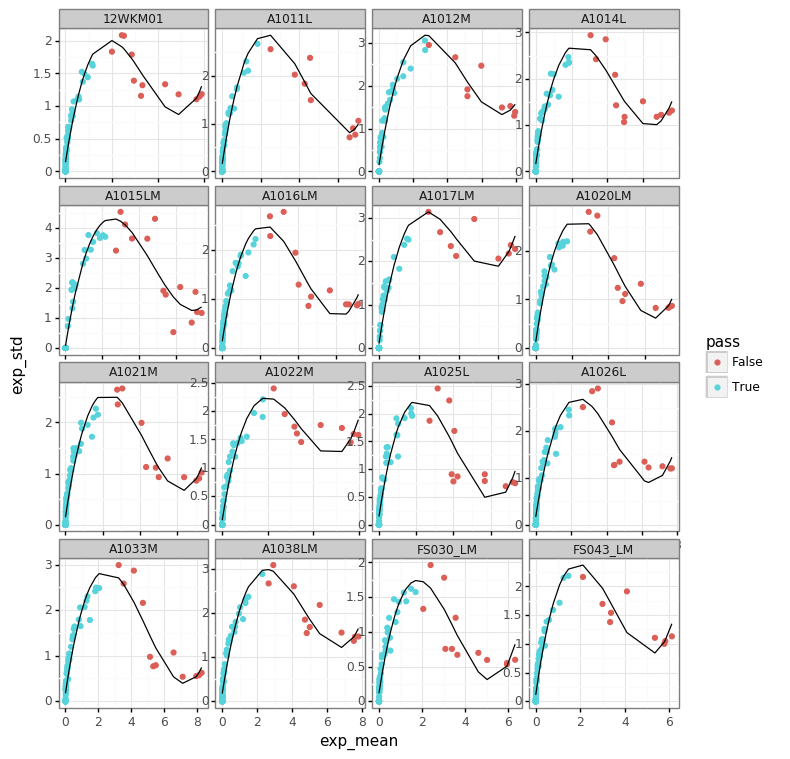

<ggplot: (-9223363285060485870)>


In [87]:
var = 'exp_std'
test = fit_poly(metrics_df_ercc, 'exp_mean', var, 3, 'patient')
test['res'] = test[var] - test['fit']
test['se'] = test['res'] ** 2
test['pass'] = [x<y for x,y in zip(test['exp_mean'], test['max_cut'])]
print(f'{var} NRMSD =', np.sqrt(test['se'].mean())/test[var].mean())
print(ggplot(test)
      +theme_bw()
      +theme(aspect_ratio = 1)
     +geom_point(aes('exp_mean', var, color = 'pass'))
     +geom_line(aes('exp_mean', 'fit'))
    +facet_wrap('~patient', scales='free')
     )


## Calculate STD for all transcripts and determine deviation from ERCC-derived fitted model
The ERCC-derived relationship between mean and STD was used to determine the deviation of observed gene-wise dispersion. 

Low-expressing genes show a greater deviation from the regression model; therefore, only genes with log expression > 0.2 are passed to subsequent analyses.

100%|██████████| 16/16 [00:01<00:00,  9.41it/s]


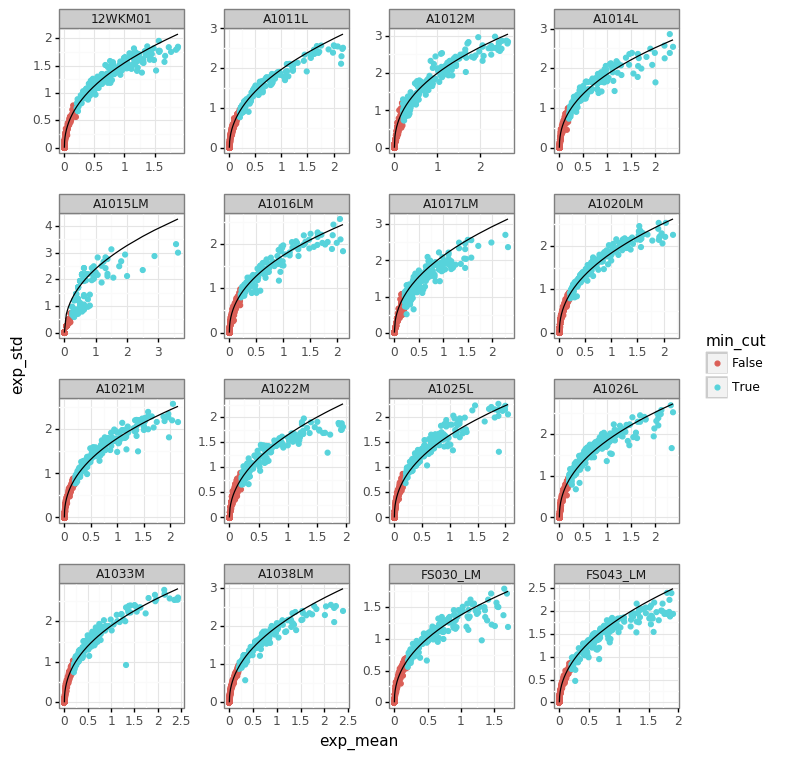

<ggplot: (-9223363285027685614)>


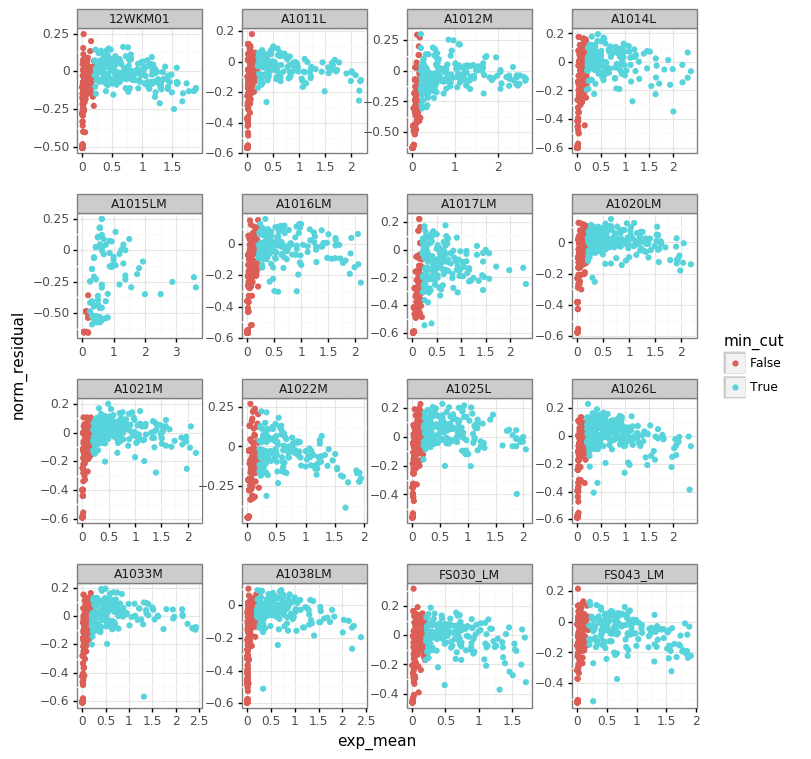

<ggplot: (-9223363285017238307)>


In [88]:
starting_adata = adata_subset2
mean_df = adata_mean (starting_adata, pre_adata)
var_df = adata_std(starting_adata, pre_adata, log = True)
var = 'exp_std'
groupby='patient'
for idx,sub_df in enumerate([var_df, mean_df]):
    if idx == 0:
        metrics_df = sub_df
    else:
        metrics_df = pd.merge(metrics_df, sub_df, 'right', ['gene',groupby])
        
metrics_df = pd.merge(test.loc[:,['max_cut','patient']].drop_duplicates(),
                      metrics_df,
                      'right',
                      'patient')  
metrics_df = metrics_df[metrics_df.max_cut > metrics_df.exp_mean]
metrics_df = fit_exp(metrics_df, 'exp_mean', var, 'patient', ercc_only=True)
# metrics_df = fit_spline(metrics_df, 'exp_mean', var, poly_num = 3, groupby = 'patient', ercc_only=True)
# metrics_df = fit_log(metrics_df, 'exp_mean', var, 'patient', ercc_only=True)
# metrics_df = fit_poly(metrics_df, 'exp_mean', var, poly_num = 2, groupby = 'patient', ercc_only=True)
metrics_df = metrics_df[[not x.startswith('ERCC-') for x in metrics_df.gene]] # remove ercc
metrics_df['residual'] = metrics_df[var] - metrics_df['fit']
metrics_df['norm_residual'] = (metrics_df[var] - metrics_df['fit']) / metrics_df['fit']
metrics_df['min_cut'] = [x> 0.2 for x in metrics_df.exp_mean]

plot_df = metrics_df.sample(n=10000)
plotnine.options.figure_size = (8,8)
print(ggplot(plot_df)
      +theme_bw()
      +theme(aspect_ratio = 1,
            panel_spacing = 0.4)
     +geom_point(aes('exp_mean', var, color = 'min_cut'))
     +geom_line(aes('exp_mean', 'fit', group = 'patient'))
     +facet_wrap('~patient',scales='free')
     )
    
for res in ['norm_residual']:
    print(ggplot(plot_df)
          +theme_bw()
          +theme(aspect_ratio = 1,
                panel_spacing = 0.4)
         +geom_point(aes('exp_mean', res, color = 'min_cut'))
         +facet_wrap('~patient',scales='free')
         )
    

## Calculate the correlation between normalized residual and patient age

Gene-wise correlation between age and normalized residual STD.

In [89]:
# tag > cutoff genes

metrics_preCorr = (metrics_df[metrics_df.min_cut == True].pivot(index = 'patient',
                                    columns = 'gene',
                                    values = 'norm_residual')
                             .replace(np.nan, 0))
metrics_preCorr = pd.merge((adata_subset2
                       .obs
                       .loc[:,['patient','age']]
                       .reset_index()
                       .drop('index', axis=1)
                       .drop_duplicates()),
                      metrics_preCorr,
                      'right',
                      'patient')

# run correlations
working_df = metrics_preCorr
age_cutoff = -2

working_df = working_df[working_df.age > age_cutoff]
gene_list = []
r_list = []
pval_list = []
zeros_list = []
for col in tqdm.tqdm([x for x in working_df.columns if x not in ['patient','age']]):

    df_slice = working_df.loc[:,['age', col]].dropna()
    r,pval = pearsonr(df_slice.age.values, df_slice[col].values)
    gene_list.append(col)
    r_list.append(r)
    pval_list.append(pval)
    zeros_list.append(np.sum(df_slice[col] == 0)) # count zero values
    
corr_df = pd.DataFrame({'gene':gene_list,
                        'r':r_list,
                        'pval':pval_list,
                        'zeros':zeros_list})

corr_df[corr_df.zeros <= 3].sort_values('pval', ascending=True).head(20)

100%|██████████| 11651/11651 [00:27<00:00, 422.50it/s]


,gene,r,pval,zeros
4018,HCFC1,0.814295,0.000123,1
3118,FAM103A1,0.796108,0.000225,1
4745,KIAA2026,0.796012,0.000225,1
502,APIP,0.791666,0.000258,1
9633,SZRD1,0.786483,0.000302,1
2601,DNLZ,0.766880,0.000528,0
6548,NRD1,0.760258,0.000630,0
6568,NSL1,0.757931,0.000669,1
8461,RTN4,-0.750198,0.000816,3
1574,CD2AP,0.742322,0.000991,2


## Top differentially dispersed gene expression

NRD1


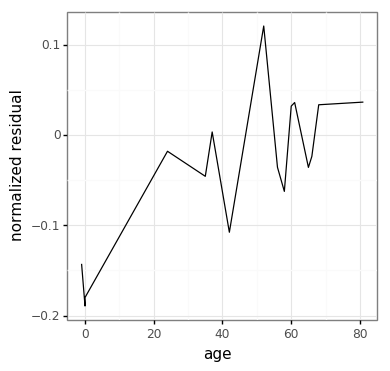

<ggplot: (8751731894343)>


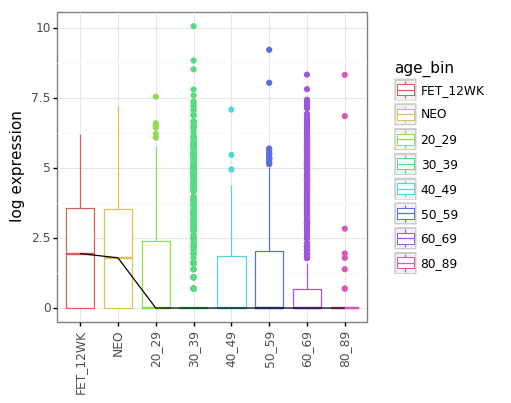

<ggplot: (8751733257357)>


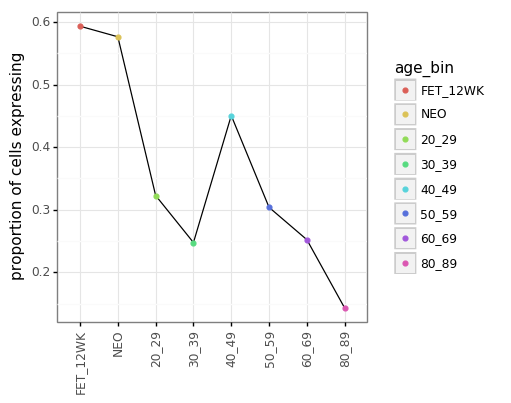

<ggplot: (8751733257280)>


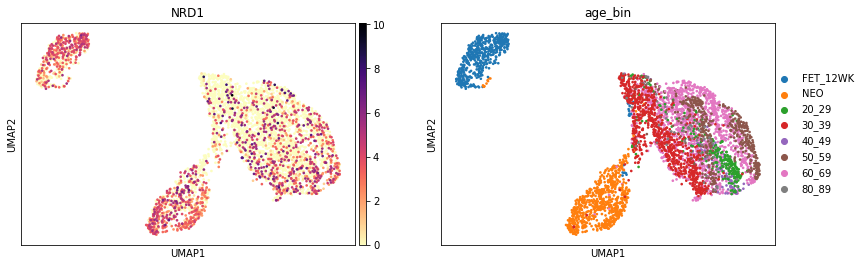

querying 1-1...done.
Finished.
1 input query terms found no hit:
	['NRD1']
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
0:  NRD1 
 N/A


In [92]:
gene = 'NRD1'
print(gene)
input_adata = adata_subset2
groupby='age_bin'

print(ggplot(metrics_preCorr.loc[:,['age', gene]])
      +theme_bw()
      +geom_line(aes('age',gene))
      +labs(y='normalized residual'))

gene2plots(input_adata, gene, groupby)
sc.pl.umap(input_adata, color=[gene, groupby], cmap='magma_r')
out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]


## Distribution of normalized residual dispersion by grouping
There does not appear to be a transcriptome-wide correlation of normalized residual dispersion and age groups.

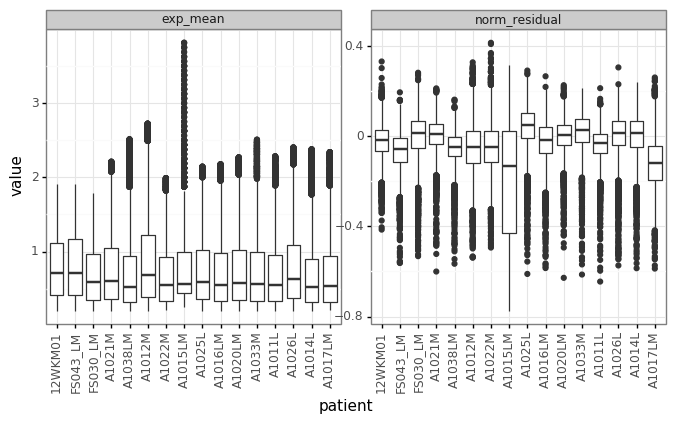

<ggplot: (-9223363285121735715)>


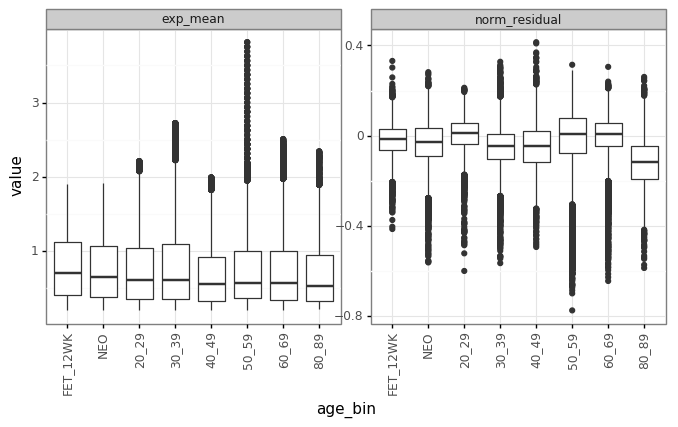

<ggplot: (8751827477147)>


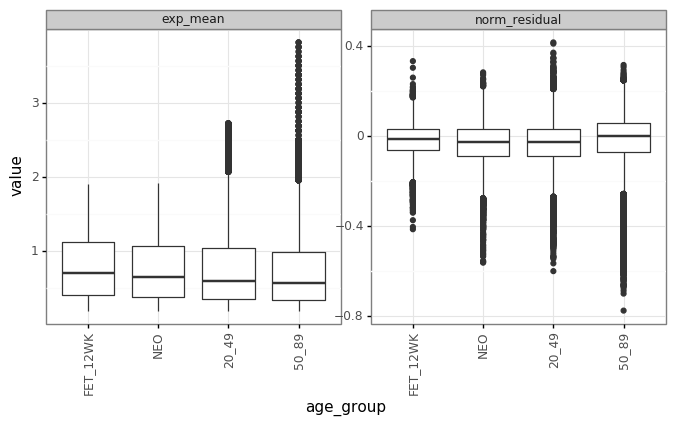

<ggplot: (-9223363285060262733)>


In [78]:
# dispersion by grouping

ordered_cat = (adata_subset2
               .obs
               .loc[:,['patient','age']]
               .reset_index()
               .drop('index', axis=1)
               .drop_duplicates()
               .sort_values('age')
                .patient
                .values
               .astype(str)
               .tolist())

plot_df = pd.merge((adata_subset2
                       .obs
                       .loc[:,['patient','age','age_bin','age_group']]
                       .reset_index()
                       .drop('index', axis=1)
                       .drop_duplicates()),
                      (metrics_df[metrics_df.min_cut == True]
                        .loc[:, ['patient','norm_residual','exp_mean']]
                        .dropna()),
                      'right',
                      'patient')
plot_df['patient'] = plot_df['patient'].astype(str).astype(CategoricalDtype(ordered_cat, ordered=True))
plot_df = pd.melt(plot_df, id_vars=['patient','age','age_bin','age_group'])

# dispression distribution per patient
plotnine.options.figure_size = (8,8)
for var in ['patient','age_bin','age_group']:
    print(ggplot(plot_df)
          +theme_bw()
          +theme(panel_spacing = 0.3,
                aspect_ratio = 1)
          +theme(axis_text_x = element_text(angle = 90))
            + geom_boxplot(aes(var,'value'))
         +facet_wrap('~variable',scales='free'))
